This a copy from this post http://krasserm.github.io/2018/02/07/deep-face-recognition/ for playing around and learn to give my Nearsoft Con Talk on Setpember 8th 2018 about Face Recognition

In [1]:
import dlib

In [2]:
import numpy as np
import os.path

class IdentityMetadata():
    def __init__(self, base, name, file):
        # dataset base directory
        self.base = base
        # identity name
        self.name = name
        # image file name
        self.file = file

    def __repr__(self):
        return self.image_path()

    def image_path(self):
        return os.path.join(self.base, self.name, self.file) 
    
def load_metadata(path):
    metadata = []
    for i in os.listdir(path):
        for f in os.listdir(os.path.join(path, i)):
            metadata.append(IdentityMetadata(path, i, f))
    return np.array(metadata)

metadata = load_metadata('images')

In [48]:
jc = metadata[0]
print(jc.base)
print(jc.name)
print(jc.file)

images
Jacques_Chirac
Jacques_Chirac_0020.jpg


## Load pretained model

`nn4.small2.v1.h5` model from [OpenFace keras](https://github.com/iwantooxxoox/Keras-OpenFace).

However `load_model` as defined in the github repo won't work, I had to copy the model in `model.py` and use `load_weights` instead.


In [20]:
from model import create_model
nn4_small2_pretrained = create_model()
nn4_small2_pretrained.load_weights('openface-model/nn4.small2.v1.h5')

## Face Alignment

The lanrdmarks model needs to be dowloaded from http://dlib.net/files/. There are two models 5 points and 68 points:

* http://dlib.net/files/shape_predictor_5_face_landmarks.dat.bz2
* http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2

Also, there's a repo for all dlib models https://github.com/davisking/dlib-models where the license is explained. 68 face landmarks cannot be used for commercial apps due to the dataset license in which it was trained.

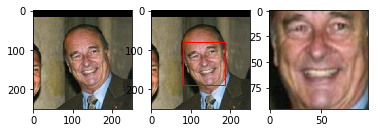

In [8]:
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches

from align import AlignDlib

%matplotlib inline

def load_image(path):
    img = cv2.imread(path, 1)
    # OpenCV loads images with color channels
    # in BGR order. So we need to reverse them
    return img[...,::-1]

# Initialize the OpenFace face alignment utility
alignment = AlignDlib('dlib-models/shape_predictor_68_face_landmarks.dat')

# Load an image of Jacques Chirac
jc_orig = load_image(metadata[2].image_path())

# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(jc_orig)

# Transform image using specified face landmark indices and crop image to 96x96
jc_aligned = alignment.align(96, jc_orig, bb, landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

# Show original image
plt.subplot(131)
plt.imshow(jc_orig)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(jc_orig)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(jc_aligned);

In [9]:
def align_image(img):
    return alignment.align(96, img, alignment.getLargestFaceBoundingBox(img), 
                           landmarkIndices=AlignDlib.OUTER_EYES_AND_NOSE)

## Embedding Vectors

In [29]:
embedded = np.zeros((metadata.shape[0], 128))

for i, m in enumerate(metadata):
    img = load_image(m.image_path())
    img = align_image(img)
    # scale RGB values to interval [0,1]
    img = (img / 255.).astype(np.float32)
    # obtain embedding vector for image
    embedded[i] = nn4_small2_pretrained.predict(np.expand_dims(img, axis=0))[0]

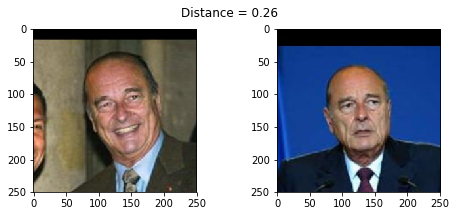

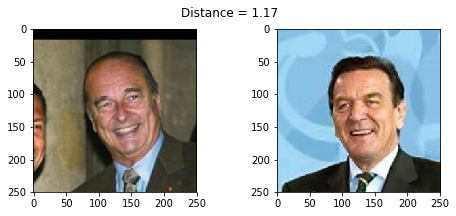

In [30]:
def distance(emb1, emb2):
    return np.sum(np.square(emb1 - emb2))

def show_pair(idx1, idx2):
    plt.figure(figsize=(8,3))
    plt.suptitle(f'Distance = {distance(embedded[idx1], embedded[idx2]):.2f}')
    plt.subplot(121)
    plt.imshow(load_image(metadata[idx1].image_path()))
    plt.subplot(122)
    plt.imshow(load_image(metadata[idx2].image_path()));    

show_pair(2, 3)
show_pair(2, 12)

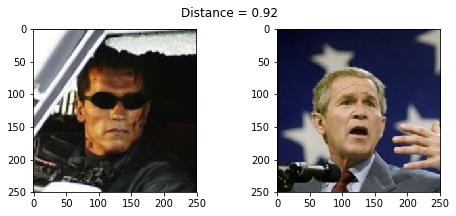

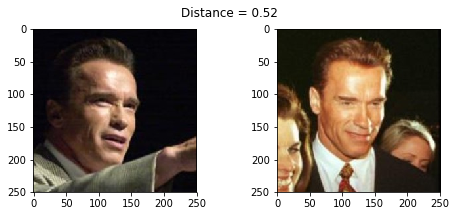

In [36]:
show_pair(50, 99)
show_pair(59, 52)

## Distance Threshold

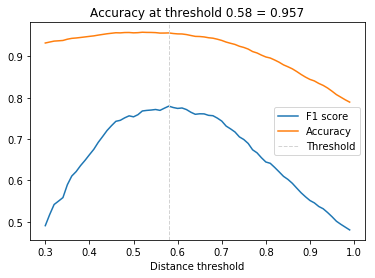

In [37]:
from sklearn.metrics import f1_score, accuracy_score

distances = [] # squared L2 distance between pairs
identical = [] # 1 if same identity, 0 otherwise

num = len(metadata)

for i in range(num - 1):
    for j in range(1, num):
        distances.append(distance(embedded[i], embedded[j]))
        identical.append(1 if metadata[i].name == metadata[j].name else 0)
        
distances = np.array(distances)
identical = np.array(identical)

thresholds = np.arange(0.3, 1.0, 0.01)

f1_scores = [f1_score(identical, distances < t) for t in thresholds]
acc_scores = [accuracy_score(identical, distances < t) for t in thresholds]

opt_idx = np.argmax(f1_scores)
# Threshold at maximal F1 score
opt_tau = thresholds[opt_idx]
# Accuracy at maximal F1 score
opt_acc = accuracy_score(identical, distances < opt_tau)

# Plot F1 score and accuracy as function of distance threshold
plt.plot(thresholds, f1_scores, label='F1 score');
plt.plot(thresholds, acc_scores, label='Accuracy');
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title(f'Accuracy at threshold {opt_tau:.2f} = {opt_acc:.3f}');
plt.xlabel('Distance threshold')
plt.legend();

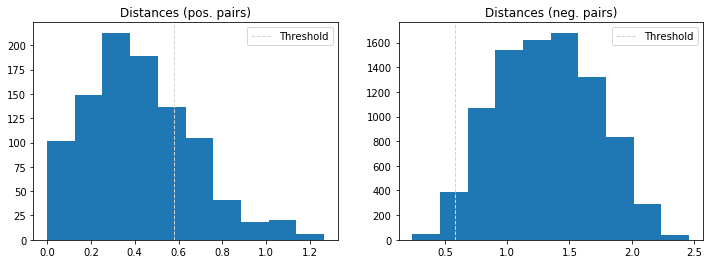

In [38]:
dist_pos = distances[identical == 1]
dist_neg = distances[identical == 0]

plt.figure(figsize=(12,4))

plt.subplot(121)
plt.hist(dist_pos)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (pos. pairs)')
plt.legend();

plt.subplot(122)
plt.hist(dist_neg)
plt.axvline(x=opt_tau, linestyle='--', lw=1, c='lightgrey', label='Threshold')
plt.title('Distances (neg. pairs)')
plt.legend();

## Face Recognition

In [105]:
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC

targets = np.array([m.name for m in metadata])

encoder = LabelEncoder()
encoder.fit(targets)

# Numerical encoding of identities
y = encoder.transform(targets)

train_idx = np.arange(metadata.shape[0]) % 2 != 0
test_idx = np.arange(metadata.shape[0]) % 2 == 0

# 50 train examples of 10 identities (5 examples each)
X_train = embedded[train_idx]
# 50 test examples of 10 identities (5 examples each)
X_test = embedded[test_idx]

y_train = y[train_idx]
y_test = y[test_idx]

knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
svc = LinearSVC()
svc2 = SVC(kernel='linear', probability=True)

knn.fit(X_train, y_train)
svc.fit(X_train, y_train)
svc2.fit(X_train, y_train)

acc_knn = accuracy_score(y_test, knn.predict(X_test))
acc_svc = accuracy_score(y_test, svc.predict(X_test))
acc_svc2 = accuracy_score(y_test, svc2.predict(X_test))

print(f'KNN accuracy = {acc_knn}, SVM accuracy = {acc_svc}, SVM2 accuracy = {acc_svc2}')

KNN accuracy = 0.96, SVM accuracy = 0.98, SVM2 accuracy = 0.98


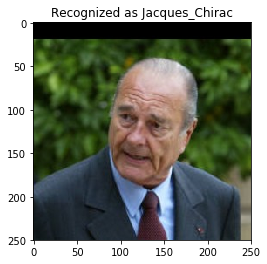

In [114]:
import warnings
# Suppress LabelEncoder warning
warnings.filterwarnings('ignore')

example_idx = 2

example_image = load_image(metadata[test_idx][example_idx].image_path())
example_prediction = svc2.predict([embedded[test_idx][example_idx]])
example_identity = encoder.inverse_transform(example_prediction)[0]

plt.imshow(example_image)
plt.title(f'Recognized as {example_identity}');

In [149]:
print(example_prediction)
svc2.predict_proba([embedded[test_idx][example_idx]])

[7]


array([[0.10326973, 0.04344432, 0.05205234, 0.08493019, 0.10496097,
        0.0907081 , 0.02801854, 0.36785676, 0.07003112, 0.05472793]])

## Dataset visualization

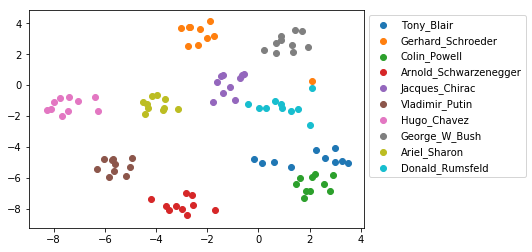

In [115]:
from sklearn.manifold import TSNE

X_embedded = TSNE(n_components=2).fit_transform(embedded)

for i, t in enumerate(set(targets)):
    idx = targets == t
    plt.scatter(X_embedded[idx, 0], X_embedded[idx, 1], label=t)   

plt.legend(bbox_to_anchor=(1, 1));

## Predict Putin

In [150]:
putin = IdentityMetadata('images-putin', 'Vladimir_Putin', 'putin.jpg')
putin_img = load_image(putin.image_path())
putin_aligned = align_image(putin_img)

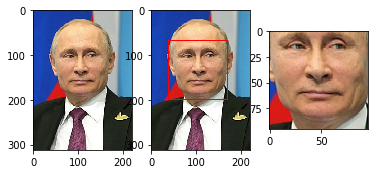

In [151]:
# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(putin_img)

# Show original image
plt.subplot(131)
plt.imshow(putin_img)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(putin_img)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(putin_aligned);

In [152]:
putin_aligned = (putin_aligned / 255.).astype(np.float32)
putin_embedded = nn4_small2_pretrained.predict(np.expand_dims(putin_aligned, axis=0))[0]

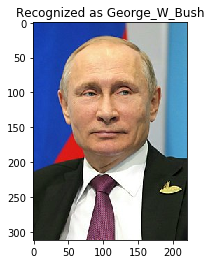

In [153]:
prediction = svc2.predict([putin_embedded])
identity = encoder.inverse_transform(prediction)[0]

plt.imshow(putin_img)
plt.title(f'Recognized as {identity}');

In [154]:
print(prediction)
svc2.predict_proba([putin_embedded])

[4]


array([[0.08996072, 0.10068941, 0.05620133, 0.1419437 , 0.16184243,
        0.03633908, 0.11181494, 0.07469953, 0.08061374, 0.14589511]])

In [137]:
personas = list()
for i in range(10):
    personas.append((i, encoder.inverse_transform(i)))
personas

[(0, 'Ariel_Sharon'),
 (1, 'Arnold_Schwarzenegger'),
 (2, 'Colin_Powell'),
 (3, 'Donald_Rumsfeld'),
 (4, 'George_W_Bush'),
 (5, 'Gerhard_Schroeder'),
 (6, 'Hugo_Chavez'),
 (7, 'Jacques_Chirac'),
 (8, 'Tony_Blair'),
 (9, 'Vladimir_Putin')]

In [98]:
y_test

array([7, 7, 7, 7, 7, 5, 5, 5, 5, 5, 9, 9, 9, 9, 9, 8, 8, 8, 8, 8, 3, 3,
       3, 3, 3, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 6, 6, 6, 6, 6, 0, 0, 0, 0,
       0, 4, 4, 4, 4, 4])

## Unknown Persona

In [120]:
trump = IdentityMetadata('images-putin', 'Donald_Trump', 'trump.jpg')
trump_img = load_image(trump.image_path())
trump_aligned = align_image(trump_img)

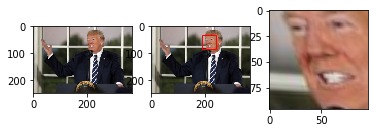

In [121]:
# Detect face and return bounding box
bb = alignment.getLargestFaceBoundingBox(trump_img)

# Show original image
plt.subplot(131)
plt.imshow(trump_img)

# Show original image with bounding box
plt.subplot(132)
plt.imshow(trump_img)
plt.gca().add_patch(patches.Rectangle((bb.left(), bb.top()), bb.width(), bb.height(), fill=False, color='red'))

# Show aligned image
plt.subplot(133)
plt.imshow(trump_aligned);

In [122]:
trump_aligned = (trump_aligned / 255.).astype(np.float32)
trump_embedded = nn4_small2_pretrained.predict(np.expand_dims(trump_aligned, axis=0))[0]

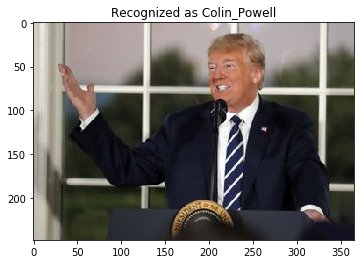

In [124]:
t_prediction = svc2.predict([trump_embedded])
t_identity = encoder.inverse_transform(t_prediction)[0]

plt.imshow(trump_img)
plt.title(f'Recognized as {t_identity}');

In [127]:
t_prediction = svc2.predict_proba([trump_embedded])

In [128]:
t_prediction

array([[0.0444316 , 0.18779579, 0.25265599, 0.0601628 , 0.05878365,
        0.09305391, 0.07246341, 0.0239714 , 0.12523282, 0.08144865]])